In [1]:
import json
import requests
import flickrapi
import pandas as pd
from tqdm import tqdm
from vincenty import vincenty
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import time
import numpy as np
from sklearn import metrics

In [2]:
df = pd.read_csv('dataset/dataset.csv')
df.head()

,id,name,lat,lon,locality,region,neighbourhood
0,50988380961,Late winter 2020-21,60.449969,22.265006,Turku,Finland Proper,Turku
1,50988488177,Late winter 2020-21,60.449969,22.265006,Turku,Finland Proper,Turku
2,50988380816,Late winter 2020-21,60.449969,22.265006,Turku,Finland Proper,Turku
3,50988380741,Late winter 2020-21,60.449969,22.265006,Turku,Finland Proper,Turku
4,50988487997,Late winter 2020-21,60.449969,22.265006,Turku,Finland Proper,Turku


In [4]:
df = df.groupby(['lon','lat']).size().reset_index().rename(columns={0:'count'})
df

,lon,lat,count
0,20.410227,67.840305,1
1,20.410397,65.853169,1
2,20.410541,65.852533,1
3,20.410555,65.855277,1
4,20.410741,65.853472,1
...,...,...,...
46399,30.407276,59.842495,1
46400,30.407408,62.855097,1
46401,30.408321,61.557012,1
46402,30.408580,66.946502,1


In [5]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))

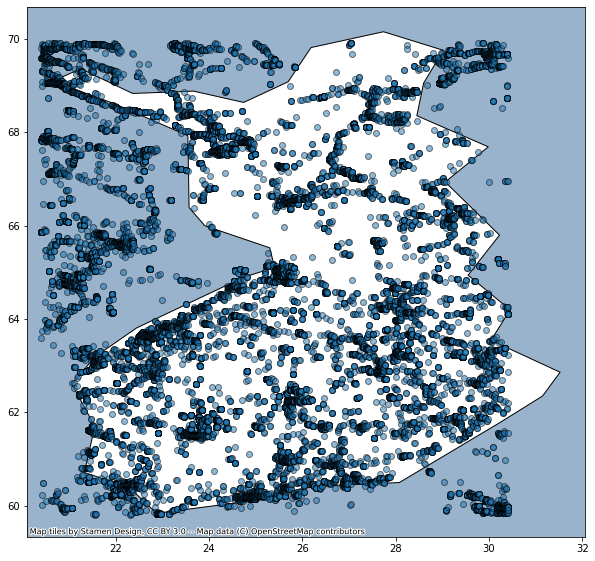

In [6]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'Finland'].plot(figsize=(10, 10),
    color='white', edgecolor='black')
ctx.add_basemap(ax, zoom=2)
gdf.plot(ax=ax, alpha=0.5, edgecolor='k')

plt.show()

In [7]:
coords = df[["lat", "lon"]].values

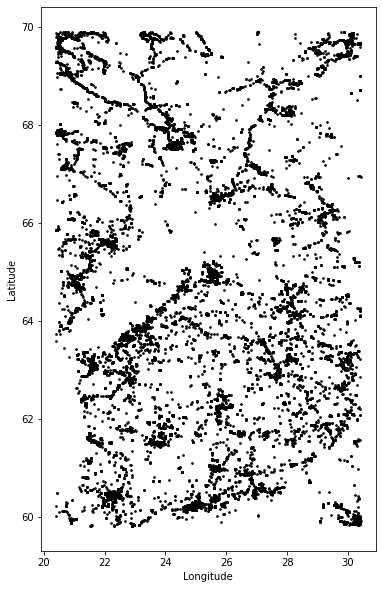

In [8]:
fig, ax = plt.subplots(figsize=[6, 10])
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [9]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 6 / kms_per_radian

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))


Clustered 46,404 points down to 1,160 clusters, for 97.5% compression in 1.16 seconds
Silhouette coefficient: 0.263


In [10]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [11]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [12]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lon,lat
43,26.308963,68.111205
44,27.401726,67.500013
45,28.354876,67.466569
46,29.359852,67.338736
47,30.338952,66.958113


In [13]:
rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
rs.to_csv('res_clust.csv', encoding='utf-8')
rs.tail()

,id,name,lat,lon,locality,region,neighbourhood,geometry
43,40177861072,Porttipahta,68.111205,26.308963,Rovanen,Lapin maakunta,NaN,POINT (26.308963 68.111205)
44,27675337675,Midnight sun in Lapland,67.500013,27.401726,Kiurujärvi,Lapin maakunta,NaN,POINT (27.401726 67.500013)
45,22114906332,CDUII_Nagaoka4x5-20151006-001,67.466569,28.354876,Martti,Lapin maakunta,NaN,POINT (28.354876 67.46656900000001)
46,31441772573,Salda littoralis,67.338736,29.359852,Salla,Lapin maakunta,NaN,POINT (29.359852 67.338736)
47,14668671224,Karelia_0020,66.958113,30.338952,Alakurtti,Murmansk Oblast,NaN,POINT (30.338952 66.958113)


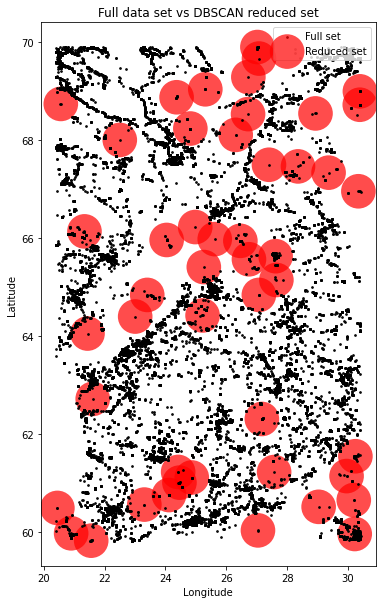

In [18]:
fig, ax = plt.subplots(figsize=[6, 10])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='red', edgecolor='None', alpha=0.7, s=1200)
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()